In [1]:
import os,sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage import io
from skimage import img_as_ubyte
import skimage.transform
import imgaug as ia
from imgaug import augmenters as iaa
import keras
from keras import applications
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

os.chdir('/home/meiker/Escritorio/monca/breca/reto_breca')

Using TensorFlow backend.
/home/meiker/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/meiker/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/meiker/deep_learning/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/meiker/deep_learning/lib/python3.6/sit

In [2]:
df = pd.read_csv("train.csv")

In [3]:
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns,uniques

df, le_encoded_cols,uniques = label_encoder(df, categorical_columns = ['label'])
dic_y = {k:v for v,k in enumerate(uniques)}

In [4]:
path = '/home/meiker/Escritorio/monca/breca/reto_breca/train_img/'

In [5]:
from sklearn.cross_validation import train_test_split

def read_train_data(d,imgsize):
    X, Y = [], []
    for img,label in df.values:
        imagen = io.imread(path+r'/'+img+ '.png')
        imagen = img_as_ubyte(skimage.transform.resize(imagen, (imgsize, imgsize)))
        X.append(imagen)
        Y.append(label)
    return np.array(X, np.float32), np.array(Y)

x_train, y_train = read_train_data(df.values,256)
x_train /= 255.

/home/meiker/deep_learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
def load_data_local_eval(val_split,x_train, y_train):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, \
        test_size=val_split, random_state=42)
    return (x_train, x_val, y_train, y_val)

x_train, x_val, y_train, y_val = load_data_local_eval(0.2,x_train, y_train)

In [7]:
x_train[:20].shape

(20, 256, 256, 3)

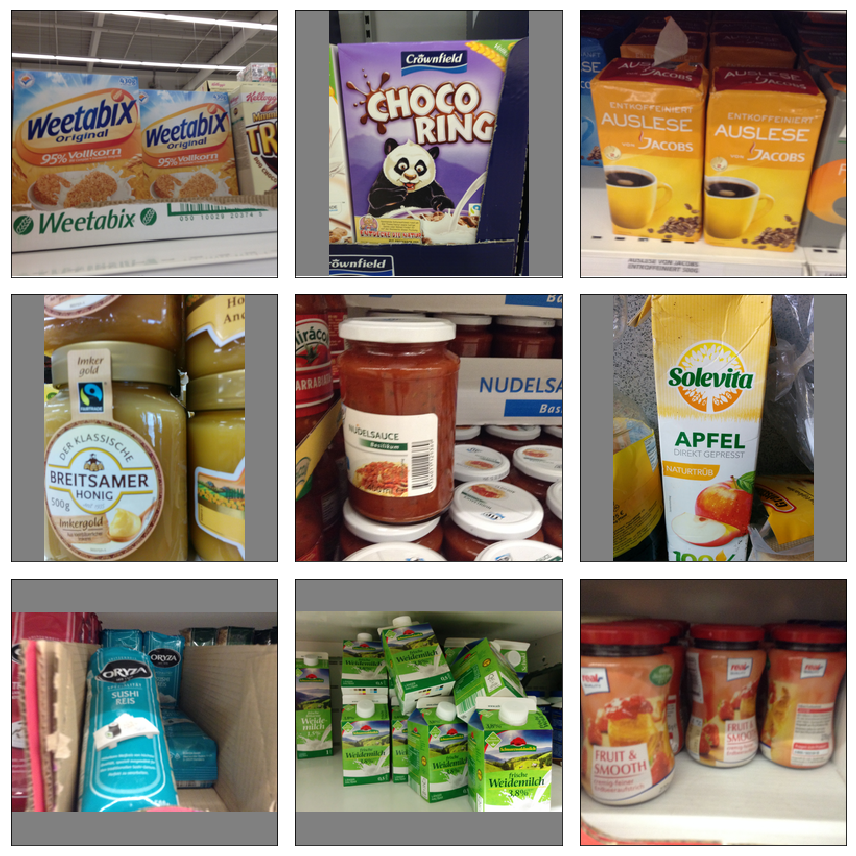

In [10]:
fig=plt.figure(figsize=(12, 12))

for i in range(9):
    #image_path = path + df.loc[i,'image_id']+'.png'
    #image_id = df.loc[i,'label']
    #img = io.imread(image_path)
    #img = np.array(img)
    fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    #plt.title(image_id)
    img = x_train[(i+1)].reshape( 256, 256, 3)
    plt.imshow(img)

plt.tight_layout()
plt.savefig('normal.png')

In [17]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Fliplr(0.5),
  iaa.Affine(
      #scale={"x": (0.35, 2.1), "y": (0.35, 2.1)},
      #translate_percent={"x": (-0.2, 0.2), "y": (-0.4, 0.4)},
      rotate=(-90, 90),
      shear=(-70, 70),
      order=[0, 1],
      mode='reflect',
  ),
])


In [18]:
images_aug = seq(images=x_train)

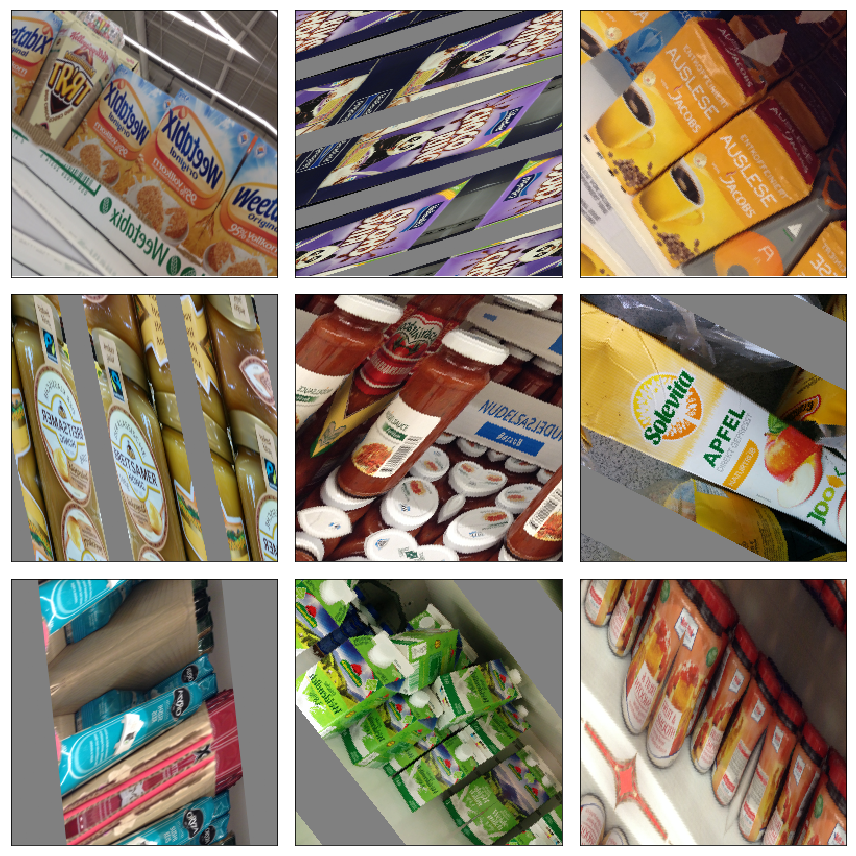

In [19]:
fig=plt.figure(figsize=(12, 12))

for i in range(9):
    #image_path = path + df.loc[i,'image_id']+'.png'
    #image_id = df.loc[i,'label']
    #img = io.imread(image_path)
    #img = np.array(img)
    fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    #plt.title(image_id)
    img = images_aug[(i+1)].reshape( 256, 256, 3)
    plt.imshow(img)

plt.tight_layout()
plt.savefig('augmentation_2.png')

In [10]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [20]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(np.max(y_train) + 1, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [21]:


train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        zca_whitening = True,
        zca_epsilon=1e-4)

#train_datagen.fit(x_train)

history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=4),
    validation_data  = (x_val,y_val),
     validation_steps = 100,
    steps_per_epoch=x_train.shape[0] // 16,
    epochs=130,
    callbacks=[ModelCheckpoint('model_VGG16', monitor='val_acc', save_best_only=True)]
)

/home/meiker/deep_learning/lib/python3.6/site-packages/keras_preprocessing/image.py:787: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/130


/home/meiker/deep_learning/lib/python3.6/site-packages/keras_preprocessing/image.py:988: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/meiker/deep_learning/lib/python3.6/site-packages/keras_preprocessing/image.py:1007: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


160/160 [==============================] - 15s 93ms/step - loss: 3.2170 - acc: 0.0734 - val_loss: 3.1525 - val_acc: 0.1073
Epoch 2/130
160/160 [==============================] - 12s 77ms/step - loss: 3.1360 - acc: 0.1062 - val_loss: 3.0365 - val_acc: 0.1726
Epoch 3/130
160/160 [==============================] - 12s 76ms/step - loss: 3.0171 - acc: 0.1516 - val_loss: 2.8629 - val_acc: 0.1835
Epoch 4/130
160/160 [==============================] - 12s 77ms/step - loss: 2.8419 - acc: 0.1781 - val_loss: 2.6037 - val_acc: 0.2488
Epoch 5/130
160/160 [==============================] - 12s 77ms/step - loss: 2.5620 - acc: 0.2578 - val_loss: 2.5456 - val_acc: 0.2722
Epoch 6/130
160/160 [==============================] - 12s 77ms/step - loss: 2.4365 - acc: 0.2719 - val_loss: 2.2747 - val_acc: 0.3110
Epoch 7/130
160/160 [==============================] - 12s 77ms/step - loss: 2.3539 - acc: 0.2969 - val_loss: 2.0488 - val_acc: 0.4044
Epoch 8/130
160/160 [==============================] - 12s 77ms/ste